In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
from IPython.display import display
%matplotlib inline

C:\Users\kanan\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\kanan\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


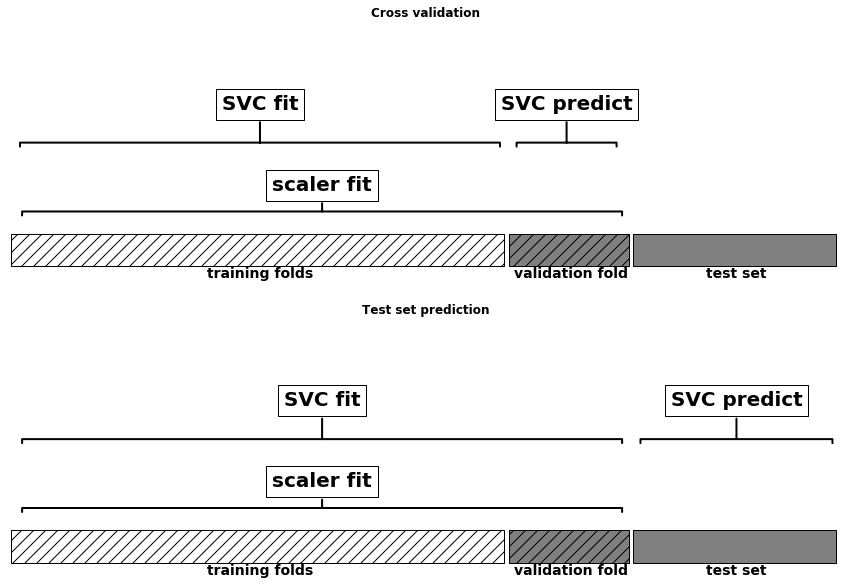

In [4]:
mglearn.plots.plot_improper_processing()

In [5]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


In [20]:
param_grid = {"svm__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "svm__gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In [24]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [25]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy(cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy(cv only on ridge): 0.91


In [27]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


In [29]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [30]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

In [31]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [33]:
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


In [39]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [40]:
print("Logistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [43]:
print("Logistic regression coefficients:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


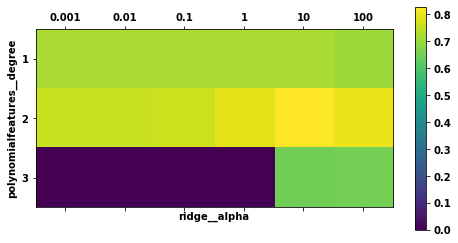

In [45]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
param_grid = {"polynomialfeatures__degree": [1, 2, 3], "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

plt.matshow(grid.cv_results_["mean_test_score"].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid["ridge__alpha"])), param_grid["ridge__alpha"])
plt.yticks(range(len(param_grid["polynomialfeatures__degree"])), param_grid["polynomialfeatures__degree"])
plt.colorbar()

In [46]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [47]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [48]:
param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [53]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([("preprocessing", StandardScaler()), ("classifier", SVC())])
param_grid = [
    {"classifier": [SVC()],
     "preprocessing": [StandardScaler(), None],
     "classifier__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
     "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100]},
    {"classifier": [RandomForestClassifier(n_estimators=100)],
     "preprocessing": [None],
     "classifier__max_features": [1, 2, 3]}
]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
